In [1]:
# Import Data 
import os
from googletrans import Translator
from striprtf.striprtf import rtf_to_text
import pandas as pd

translator = Translator(service_urls=["translate.googleapis.com"])  

# Defining Key Functions

In [2]:
# import_rtf_files

def import_rtf_files(folder_path):
    rtf_files = []
    title_names = []
    for file_name in os.listdir(folder_path):
        if file_name.endswith('.rtf'):
            title_names.append(file_name)
            file_path = os.path.join(folder_path, file_name)
            with open(file_path) as file:
                doc = rtf_to_text(file.read())
                #remove tabs
                doc = doc.replace('\t', '')
                rtf_files.append(doc)
    return title_names, rtf_files

# Import Metadata

In [3]:
meta_df = pd.read_excel(os.path.join(os.getcwd(), "raw_data/Results list for_omgevingswet.xlsx")).drop("Summary", axis=1)
meta_df.index = meta_df.index + 1
meta_df.head()

,Headline,Publication,Date
1,14 dingen die je beter niet kunt doen tijdens ...,"NRC, LEVEN; Blz. 8, 837 words",2023-06-13
2,216 appartementen gaan plat in Oosterhoutse wi...,"AD/Algemeen Dagblad.nl, 600 words",2024-04-12
3,Aanbod van nieuwbouwhuizen blijft flink achter,"De Limburger, WONINGMARKT; Blz. 57, 392 words",2022-08-06
4,Aanpak fijnstof: regie ontbreekt,"De Limburger, 02; Blz. 2, 352 words",2017-03-25
5,Aanvraag vergunningen moet sneller en eenvoudiger,"De Limburger, VERBETERPLAN; Blz. 5, 258 words",2020-10-15


# Import Article Files and Translate

In [4]:
# Test single entry
s_title_texts, dutch_texts = import_rtf_files(os.path.join(os.getcwd(), "raw_data/"))

for dutch_text in dutch_texts:
    split_texts = dutch_text.split("End of Document")
    split_texts.pop()
    print(len(split_texts))

100
100
100
100
100
100
53


In [12]:
# import files
folder_paths = [os.path.join(os.getcwd(), "raw_data/")]

dutch_texts = []
english_texts = []
id_texts = []
id = 1

#assume only single path
for folder_path in folder_paths:

    # for a single path
    s_title_texts, s_dutch_texts = import_rtf_files(folder_path)

    #for each 100 files in a rtf
    for dutch_text in s_dutch_texts:

        # split and give ID
        split_texts = dutch_text.split("End of Document")
        split_texts.pop() # remove last entry

        # translate rtf_texts
        for split_text in split_texts: 
            
            #add ID
            id_texts.append(id)
            id = id + 1

            #translate entry
            english_text = translator.translate(split_text, src='nl', dest='en') 
            english_texts.append(english_text) 

            # add original dutch text
            dutch_texts.append(split_text)

In [13]:
# Test if all files are parsed
# 7 Files in total

print (len(id_texts),len(dutch_texts),len(english_texts))
#print(id_texts[4])
#print(dutch_texts[4])
#print(english_texts[4])

653 653 653


# Compile Corpus with Metadata

In [14]:
# Create df from origin data
text_df = pd.DataFrame({'Dutch': dutch_texts, 'English': english_texts})
text_df.index = id_texts

text_df.head()

,Dutch,English
1,\n\n\n\n\n14 dingen die je beter niet kunt doe...,"Translated(src=nl, dest=en, text=14 things not..."
2,\n\n\n\n\n\n\n216 appartementen gaan plat in O...,"Translated(src=nl, dest=en, text=216 apartment..."
3,\n\n\n\n\n\n\nAanbod van nieuwbouwhuizen blijf...,"Translated(src=nl, dest=en, text=The supply of..."
4,\n\n\n\n\n\n\nAanpak fijnstof: regie ontbreekt...,"Translated(src=nl, dest=en, text=Tackling part..."
5,\n\n\n\n\n\n\nAanvraag vergunningen moet snell...,"Translated(src=nl, dest=en, text=Applying for ..."


In [26]:
merged_df = pd.merge(meta_df, text_df, left_index=True, right_index=True)
merged_df.head()

,Headline,Publication,Date,Dutch,English
1,14 dingen die je beter niet kunt doen tijdens ...,"NRC, LEVEN; Blz. 8, 837 words",2023-06-13,\n\n\n\n\n14 dingen die je beter niet kunt doe...,"Translated(src=nl, dest=en, text=14 things not..."
2,216 appartementen gaan plat in Oosterhoutse wi...,"AD/Algemeen Dagblad.nl, 600 words",2024-04-12,\n\n\n\n\n\n\n216 appartementen gaan plat in O...,"Translated(src=nl, dest=en, text=216 apartment..."
3,Aanbod van nieuwbouwhuizen blijft flink achter,"De Limburger, WONINGMARKT; Blz. 57, 392 words",2022-08-06,\n\n\n\n\n\n\nAanbod van nieuwbouwhuizen blijf...,"Translated(src=nl, dest=en, text=The supply of..."
4,Aanpak fijnstof: regie ontbreekt,"De Limburger, 02; Blz. 2, 352 words",2017-03-25,\n\n\n\n\n\n\nAanpak fijnstof: regie ontbreekt...,"Translated(src=nl, dest=en, text=Tackling part..."
5,Aanvraag vergunningen moet sneller en eenvoudiger,"De Limburger, VERBETERPLAN; Blz. 5, 258 words",2020-10-15,\n\n\n\n\n\n\nAanvraag vergunningen moet snell...,"Translated(src=nl, dest=en, text=Applying for ..."


In [40]:
# Iterate through every row in the DataFrame
for index, row in merged_df.iterrows():
    pub_data = row['Publication'].split(',')
    merged_df.at[index,'Source'] = pub_data[0]
    merged_df.at[index, 'Words'] = pub_data[-1].replace(" words","")

merged_df.head()

,Headline,Publication,Date,Dutch,English,Source,Words
1,14 dingen die je beter niet kunt doen tijdens ...,"NRC, LEVEN; Blz. 8, 837 words",2023-06-13,\n\n\n\n\n14 dingen die je beter niet kunt doe...,"Translated(src=nl, dest=en, text=14 things not...",NRC,837
2,216 appartementen gaan plat in Oosterhoutse wi...,"AD/Algemeen Dagblad.nl, 600 words",2024-04-12,\n\n\n\n\n\n\n216 appartementen gaan plat in O...,"Translated(src=nl, dest=en, text=216 apartment...",AD/Algemeen Dagblad.nl,600
3,Aanbod van nieuwbouwhuizen blijft flink achter,"De Limburger, WONINGMARKT; Blz. 57, 392 words",2022-08-06,\n\n\n\n\n\n\nAanbod van nieuwbouwhuizen blijf...,"Translated(src=nl, dest=en, text=The supply of...",De Limburger,392
4,Aanpak fijnstof: regie ontbreekt,"De Limburger, 02; Blz. 2, 352 words",2017-03-25,\n\n\n\n\n\n\nAanpak fijnstof: regie ontbreekt...,"Translated(src=nl, dest=en, text=Tackling part...",De Limburger,352
5,Aanvraag vergunningen moet sneller en eenvoudiger,"De Limburger, VERBETERPLAN; Blz. 5, 258 words",2020-10-15,\n\n\n\n\n\n\nAanvraag vergunningen moet snell...,"Translated(src=nl, dest=en, text=Applying for ...",De Limburger,258


# Filter Corpus (Noise)

In [45]:
# Filter Repetitions

filter_df = merged_df.drop_duplicates(subset=['Headline',"Words"])
print("filtered entries: ", len(merged_df) - len(filter_df) )

filtered entries:  41


# Export Corpus as CSV

In [43]:
# Write DataFrame to CSV file

dir_path = os.path.dirname(os.path.realpath('__file__'))
file_path = os.path.join(dir_path, "translated_data",'full_dataset.xlsx')
filter_df.to_excel(file_path, index_label= False)

# RUN HERE IN FUTURE

# Filter Corpus (Choice)

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
merged_df = pd.read_excel(os.path.join(os.getcwd(), "translated_data/full_dataset.xlsx"), index_col=0)
merged_df.tail()

,Headline,Publication,Date,Dutch,English,Source,Words
649,Zwemmen wordt steeds meer een schaarse luxe,"De Limburger, Blz. 20, 18, 21, 19, 2356 words",2024-04-20,\n\n\n\n\n\n\nZwemmen wordt steeds meer een sc...,"Translated(src=nl, dest=en, text=Swimming is i...",De Limburger,2356
650,Zwermdemocratiemoet jongeren naar de politiek ...,"De Limburger, Blz. 45, 44, 861 words",2021-09-18,\n\n\n\n\n\n\nZwermdemocratiemoet jongeren naa...,"Translated(src=nl, dest=en, text=Swarm democra...",De Limburger,861
651,‘Land van Cuijk had zelf op de rem moeten trap...,"AD/Algemeen Dagblad.nl, 504 words",2024-02-02,\n\n\n\n\n\n\n‘Land van Cuijk had zelf op de r...,"Translated(src=nl, dest=en, text='Land van Cui...",AD/Algemeen Dagblad.nl,504
652,"‘Praat mee over toekomst van Goeree’, welke ka...","AD/Algemeen Dagblad.nl, 603 words",2023-12-20,\n\n\n\n\n\n\n‘Praat mee over toekomst van Goe...,"Translated(src=nl, dest=en, text='Have a say i...",AD/Algemeen Dagblad.nl,603
653,‘Stevige impuls’ voor woningbouw Meierijstad: ...,"AD/Algemeen Dagblad.nl, 268 words",2023-12-21,\n\n\n\n\n\n\n‘Stevige impuls’ voor woningbouw...,"Translated(src=nl, dest=en, text='Strong impet...",AD/Algemeen Dagblad.nl,268


In [4]:
# Convert the 'Date' column to datetime
merged_df['Date'] = pd.to_datetime(merged_df['Date'])

In [17]:
merged_df['Date']

1     2023-06-13
2     2024-04-12
3     2022-08-06
4     2017-03-25
5     2020-10-15
         ...    
649   2024-04-20
650   2021-09-18
651   2024-02-02
652   2023-12-20
653   2023-12-21
Name: Date, Length: 612, dtype: datetime64[ns]

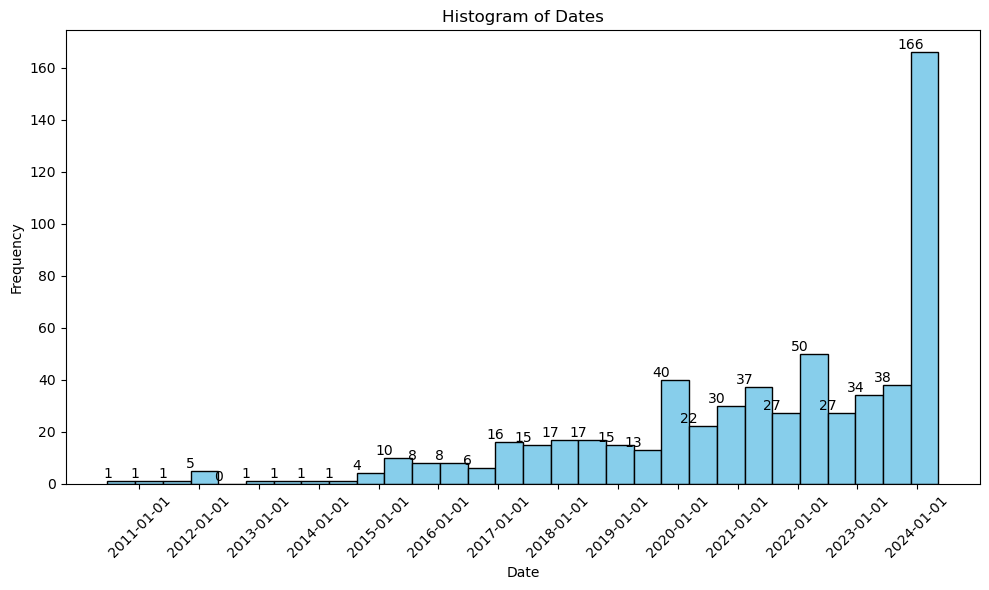

In [21]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming merged_df['Date'] contains datetime objects
# Extract years from the datetime objects
merged_df['Year'] = merged_df['Date'].dt.year

plt.figure(figsize=(10, 6))
hist, bins, _ = plt.hist(merged_df['Date'], bins=30, color='skyblue', edgecolor='black')
plt.title('Histogram of Dates')
plt.xlabel('Date')
plt.ylabel('Frequency')

# Set x-ticks to be yearly
plt.xticks(pd.date_range(start=min(merged_df['Date']), end=max(merged_df['Date']), freq='YS'), rotation=45)

# Add quantity information on each bar
for i in range(len(hist)):
    plt.text(bins[i], hist[i], str(int(hist[i])), ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [39]:
merged_df[merged_df['Year'] == 2024]

,Headline,Publication,Date,Dutch,English,Source,Words,Year
2,216 appartementen gaan plat in Oosterhoutse wi...,"AD/Algemeen Dagblad.nl, 600 words",2024-04-12,\n\n\n\n\n\n\n216 appartementen gaan plat in O...,"Translated(src=nl, dest=en, text=216 apartment...",AD/Algemeen Dagblad.nl,600,2024
8,Actie: nu al ‘honderden’ bezwaren tegen zonnep...,"AD/Algemeen Dagblad.nl, 430 words",2024-01-25,\n\n\n\n\n\n\nActie: nu al ‘honderden’ bezware...,"Translated(src=nl, dest=en, text=Action: alrea...",AD/Algemeen Dagblad.nl,430,2024
13,Alles op een grote hoop: hup de Omgevingswet,"De Limburger, POLLUX & VERDONSCHOT; Blz. 2, 45...",2024-01-04,\n\n\n\n\n\n\nAlles op een grote hoop: hup de ...,"Translated(src=nl, dest=en, text=Everything in...",De Limburger,452,2024
21,Anketien geeft dieren een stem met protestbord...,"AD/Algemeen Dagblad.nl, 650 words",2024-03-25,\n\n\n\n\n\n\nAnketien geeft dieren een stem m...,"Translated(src=nl, dest=en, text=Anketien give...",AD/Algemeen Dagblad.nl,650,2024
25,Argos: ‘Heros overtreedt milieuregels’,"AD/Algemeen Dagblad.nl, 577 words",2024-04-26,\n\n\n\n\n\n\nArgos: ‘Heros overtreedt milieur...,"Translated(src=nl, dest=en, text=Argos: 'Heros...",AD/Algemeen Dagblad.nl,577,2024
...,...,...,...,...,...,...,...,...
622,Woedende bewoners bij informatieavond over ‘me...,"AD/Algemeen Dagblad.nl, 632 words",2024-03-27,\n\n\n\n\n\n\nWoedende bewoners bij informatie...,"Translated(src=nl, dest=en, text=Furious resid...",AD/Algemeen Dagblad.nl,632,2024
628,Woningbouwruzie verder op scherp,"NRC, ECONOMIE; Blz. 8, 791 words",2024-03-09,\n\n\n\n\n\n\nWoningbouwruzie verder op scherp...,"Translated(src=nl, dest=en, text=Housing dispu...",NRC,791,2024
638,Zorgden de nieuwe Tilburgse waterbergingen voo...,"AD/Algemeen Dagblad.nl, 704 words",2024-01-25,\n\n\n\n\n\n\nZorgden de nieuwe Tilburgse wate...,"Translated(src=nl, dest=en, text=Did the new T...",AD/Algemeen Dagblad.nl,704,2024
649,Zwemmen wordt steeds meer een schaarse luxe,"De Limburger, Blz. 20, 18, 21, 19, 2356 words",2024-04-20,\n\n\n\n\n\n\nZwemmen wordt steeds meer een sc...,"Translated(src=nl, dest=en, text=Swimming is i...",De Limburger,2356,2024


# Export Translated Files as TXT

In [44]:
for i in range(len(filter_df['Headline'])):
    
    # title name id+ .txt
    new_title = str(filter_df.index[i]) + ".txt"

    file_path = os.path.join("translated_data/", new_title)

    with open(file_path, 'w') as file:
        file.write(str(filter_df["English"].iloc[i]))